# SMS Spam Detection 

Goal of this notebook is to test different well-known classifiers in combination with a plethora of features and see how they perform on the given dataset

## Import Libraries


In [1]:
# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")  
# Specialized container datatypes
import collections
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Natural language processing library
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
# For basic cleaning and data preprocessing 
import re
import string 
# Machine learning libary
from sklearn.feature_extraction.text import CountVectorizer
# For wordcloud generating 
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pantelis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis (EDA)



Read the data using pandas' read_csv method and let's look at the dataset info to see if everything is alright

In [2]:
DATAPATH = 'data/spam.csv'
df = pd.read_csv(DATAPATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB


In [3]:
# Shape of our data
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

Have a look on the first 5 rows of the dataset


In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message" respectively.  Also drop any row which has any NaN value

In [5]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
df.rename(columns = {'v1':'label','v2':'message'}, inplace=True)
df.dropna(inplace=True)

Let's see the first 5 rows of the dataset again

In [6]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Target count for data


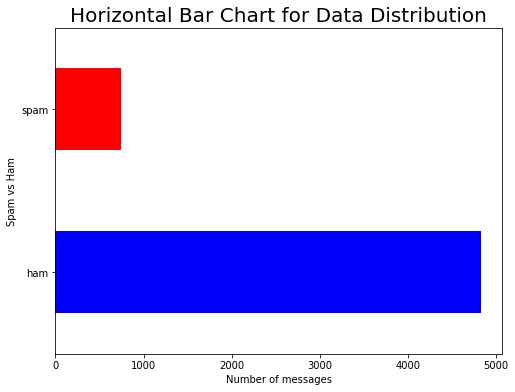

In [7]:
df['label'].value_counts().plot(kind = 'barh', color = ['blue','red'], figsize = (8, 6))
plt.title('Horizontal Bar Chart for Data Distribution', fontsize = 20)
plt.ylabel('Spam vs Ham')
plt.xlabel('Number of messages')
plt.show()

Vizualize data distribution using pie chart


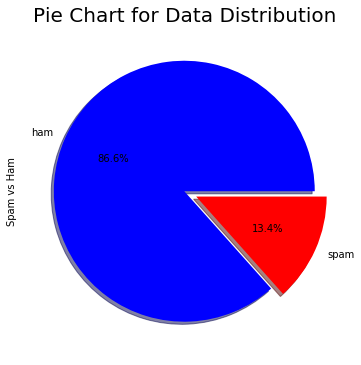

In [8]:
df['label'].value_counts().plot(kind = 'pie', colors = ['blue','red'], explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.title('Pie Chart for Data Distribution', fontsize = 20)
plt.ylabel('Spam vs Ham')
plt.show()

It's crystal clear that 'ham' sms are 6.5 times more than the 'spam' ones. 
- We have to be very careful when we gonna split our data set into train and test set or when we gonna use cross-validation. Otherwise we have a chance of our training model being skewed towards normal messages. That's will happen if the sample we choose to train our model consists majorly of 'ham' sms. In this case, it's very propable to end up predicting everything as 'ham'.
- Also precision is very important as we don't want to predict any 'ham' sms as 'spam'. Actually, we don't mind if we miss any odd 'spam' sms.

Let's have a look into the data grouped by into labels 'ham' or 'spam'


In [9]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's see how a ham and a spam sms looks like

In [10]:
# Pick at random a ham sms 
df.loc[df['label'] == 'ham'].sample()

,label,message
2765,ham,and picking them up from various points


In [11]:
# Pick at random a spam sms 
df.loc[df['label'] == 'spam'].sample()

,label,message
1792,spam,WIN: We have a winner! Mr. T. Foley won an iPo...


Now let's see 30 most frequent occuring words 

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

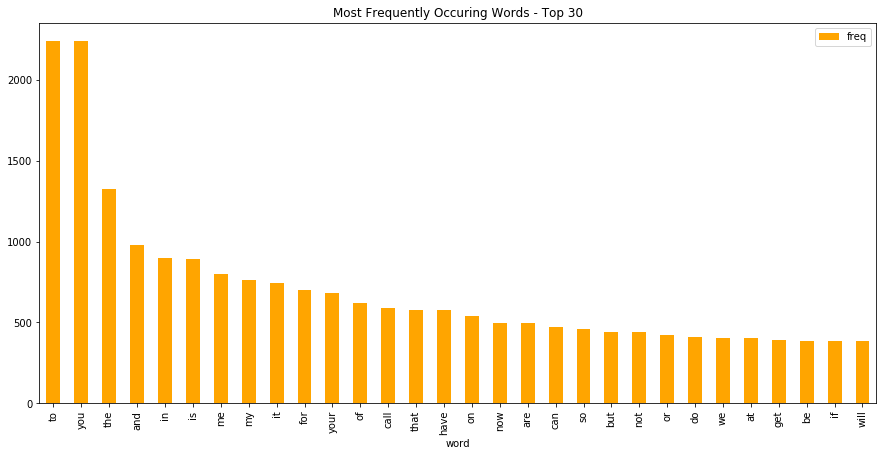

In [12]:
cv = CountVectorizer()
words = cv.fit_transform(df.message)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'orange')
plt.title("Most Frequently Occuring Words - Top 30")

It's time to generate wordclouds for both 'spam' and 'ham' sms to have a rough estimate of the words that has the highest frequency in the data

In [13]:
# First define a function to find all words (excluding numbers and stopwords) of each category
def getWords(label):
    temp_words = ' '.join(list(df.loc[df['label'] == label]['message'])) 
    lst_words = []
    words = [word.lower() for word in word_tokenize(temp_words) 
             if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    lst_words = lst_words + words
    return lst_words

In [14]:
# Get both spam and ham words
spam_words = getWords('spam')
ham_words = getWords('ham')

In [15]:
def generate_wordcloud(words):
    # exclude stop words 
    wordcloud = WordCloud(max_words=1000,width=840, height=540).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

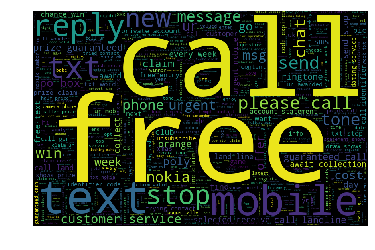

In [16]:
# generate wordcloud for 'spam' sms
generate_wordcloud(' '.join(spam_words))

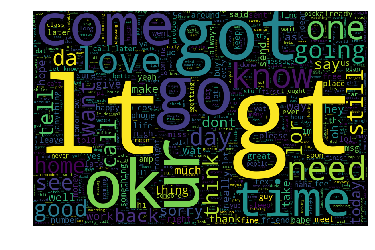

In [17]:
# generate wordcloud for 'ham' sms
generate_wordcloud(' '.join(ham_words))

As we see words like 'free', 'text', 'call', 'reply', 'mobile' and 'now' appear very often in 'spam' sms. Respectively the most frequent words in 'ham' sms are 'ok', 'will', 'now', 'got', 'gt', 'lt' and etc

Let's get more precise and find out what are the 20 most frequent words in each category

In [18]:
# 20 most frequent spam words
Counter = collections.Counter(spam_words)
most_occur_spam_words = Counter.most_common(20)
df_most_occur_spam_words = pd.DataFrame(most_occur_spam_words, columns=['word','frequency'])
df_most_occur_spam_words

,word,frequency
0,call,346
1,free,217
2,txt,156
3,u,144
4,ur,144
5,mobile,123
6,text,121
7,stop,114
8,claim,113
9,reply,104


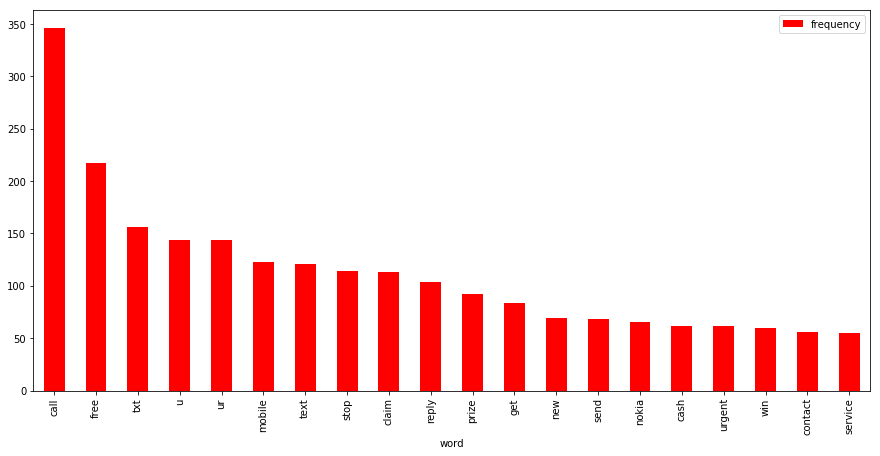

In [19]:
df_most_occur_spam_words.plot(x='word', y='frequency', kind='bar', figsize=(15, 7), color = 'red')

In [20]:
# 20 most frequent ham words
Counter = collections.Counter(ham_words)
most_occur_ham_words = Counter.most_common(20)
df_most_occur_ham_words = pd.DataFrame(most_occur_ham_words, columns=['word','frequency'])
df_most_occur_ham_words

,word,frequency
0,u,973
1,gt,318
2,lt,316
3,get,301
4,go,246
5,got,242
6,ur,237
7,ok,235
8,know,234
9,like,231


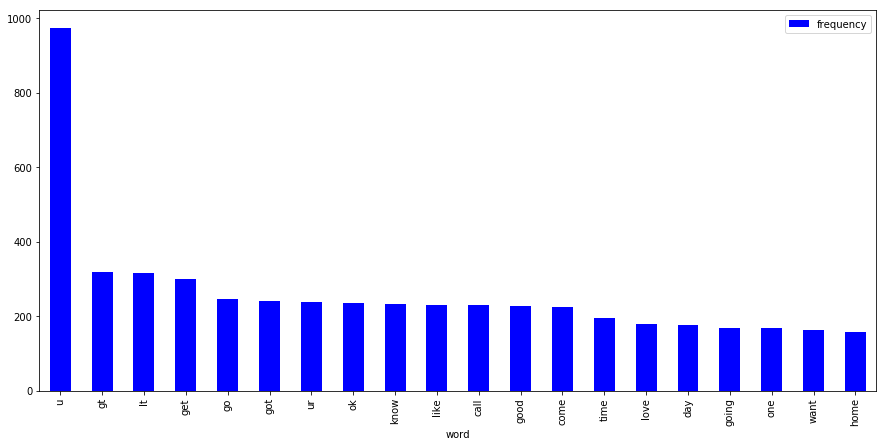

In [21]:
df_most_occur_ham_words.plot(x='word', y='frequency', kind='bar', figsize=(15, 7), color = 'blue')

In many cases bigrams is also an important tool in data analysis. So let's see if there some words which occur more frequently than the other ones for each category

In [22]:
# top 20 bigrams in spam_words
spam_bigrams = ngrams(spam_words, 2)
spam_bigrams_freq = collections.Counter(spam_bigrams)
most_freq_spam_bigrams = spam_bigrams_freq.most_common(20)
df_most_freq_spam_bigrams = pd.DataFrame(most_freq_spam_bigrams, columns=['bigram','frequency'])
df_most_freq_spam_bigrams

,bigram,frequency
0,"(please, call)",45
1,"(po, box)",24
2,"(guaranteed, call)",23
3,"(prize, guaranteed)",22
4,"(call, landline)",22
5,"(selected, receive)",19
6,"(contact, u)",19
7,"(send, stop)",19
8,"(every, week)",19
9,"(await, collection)",19


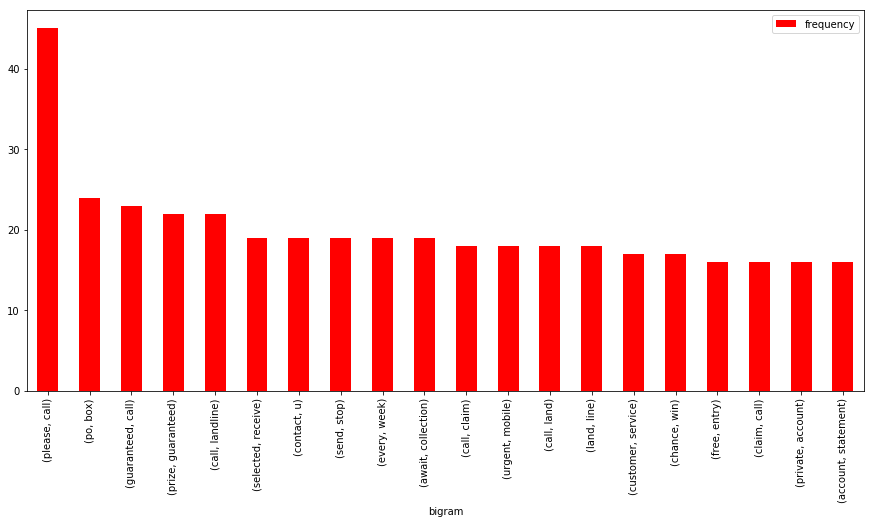

In [23]:
df_most_freq_spam_bigrams.plot(x='bigram', y='frequency', kind='bar', figsize=(15, 7), color = 'red')

In [24]:
# top 20 bigrams in ham_words
ham_bigrams = ngrams(ham_words, 2)
ham_bigrams_freq = collections.Counter(ham_bigrams)
most_freq_ham_bigrams = ham_bigrams_freq.most_common(20)
df_most_freq_ham_bigrams = pd.DataFrame(most_freq_ham_bigrams, columns=['bigram','frequency'])
df_most_freq_ham_bigrams

,bigram,frequency
0,"(lt, gt)",276
1,"(gon, na)",58
2,"(call, later)",50
3,"(let, know)",39
4,"(sorry, call)",38
5,"(r, u)",37
6,"(u, r)",35
7,"(good, morning)",30
8,"(take, care)",29
9,"(u, wan)",29


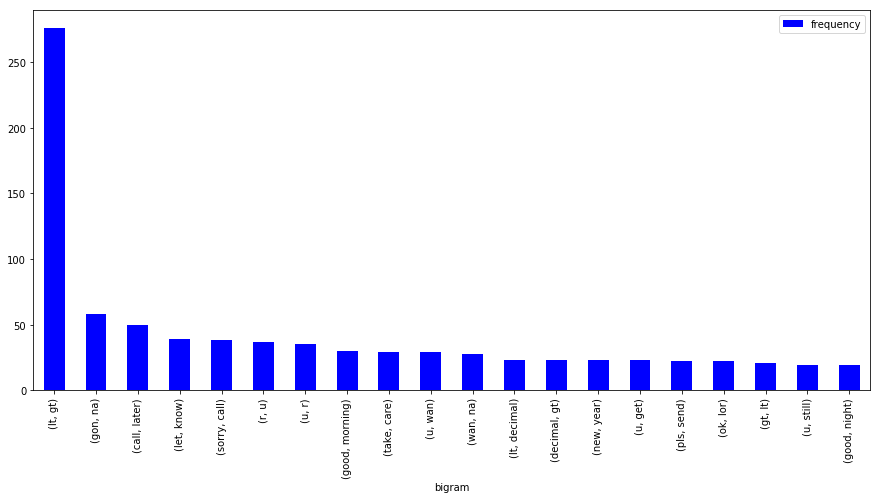

In [25]:
df_most_freq_ham_bigrams.plot(x='bigram', y='frequency', kind='bar', figsize=(15, 7), color = 'blue')

## Preprocessing 

Now define our text precessing function. It will remove any punctuation and stopwords. Also it will convert all letters to lowercase and perform stemming aswell.

In [35]:
def preprocess_text(text):
    # remove all punctuation
    text = re.sub(r'[^\w\d\s]', ' ', text)
    # collapse all white spaces
    text = re.sub(r'\s+', ' ', text)
    # convert to lower case
    text = re.sub(r'^\s+|\s+?$', '', text.lower())
    # remove stop words and perform stemming
    stop_words = nltk.corpus.stopwords.words('english')
    porter = nltk.SnowballStemmer('english')
    return ' '.join(
        porter.stem(term) 
        for term in text.split()
        if term not in set(stop_words)
    )
    

In [38]:
df['processed_text'] = df.message.apply(lambda row : preprocess_text(row))
df.head()

,label,message,processed_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


## Feature Engineering